# Deep EDA & Advanced Preprocessing 📊

This notebook covers the **visual analysis** and **rigorous preprocessing** required for high-performance modeling.

**Objectives:**
1. **Deep EDA Suite**: 
    - **Univariate**: Distributions (Log vs Linear).
    - **Bivariate**: Scatter plots (Sqft vs Price) and Boxplots (Grade, View vs Price).
    - **Geospatial**: Wealth Maps.
    - **Visual**: Satellite Imagery samples.
2. **Feature Engineering**: Create robust features (Age, Renovation, Zipcode Embeddings).
3. **Dual Pipeline Setup**: 
    - **Basic Pipeline**: Standard features for V3/V4 Models.
    - **SOTA Pipeline (KNN)**: Advanced Spatial-KNN features for the V5 Ensemble.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Set plot style
sns.set(style="whitegrid")
%matplotlib inline

# --- ROBUST PATH DETECTION ---
def detect_environment():
    paths = {
        "train": None,
        "test": None,
        "images": None
    }
    
    # 1. KAGGLE DETECTION
    if os.path.exists("/kaggle/input"):
        print("Environment: Kaggle Detected")
        for root, dirs, files in os.walk("/kaggle/input"):
            for f in files:
                if f == "train.xlsx": paths["train"] = os.path.join(root, f)
                elif f == "test.xlsx": paths["test"] = os.path.join(root, f)
            if "dataset" in dirs:
                paths["images"] = os.path.join(root, "dataset")
            elif "satellite_images" in dirs: # Fallback
                paths["images"] = os.path.join(root, "satellite_images")
        return paths

    # 3. LOCAL DETECTION
    print("Environment: Local Detected")
    paths["train"] = "train.xlsx"
    paths["test"] = "test.xlsx"
    paths["images"] = "satellite_images"
    
    return paths

# ------------------- RUN -------------------
PATHS = detect_environment()
if PATHS["train"] and os.path.exists(PATHS["train"]):
    full_df = pd.read_excel(PATHS["train"])
    full_df.drop_duplicates(subset=['id'], keep='first', inplace=True)
    full_df = full_df[full_df['bedrooms'] != 33]
    full_df['date'] = pd.to_datetime(full_df['date'])
    print(f"Data Loaded. Shape: {full_df.shape}")
else:
    print("TRAIN DATA NOT FOUND! Please check paths.")

Environment: Kaggle Detected
Data Loaded. Shape: (16109, 21)


## 2. Deep Exploratory Data Analysis (EDA) 🔍

### 2.1 Univariate: Distributions

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


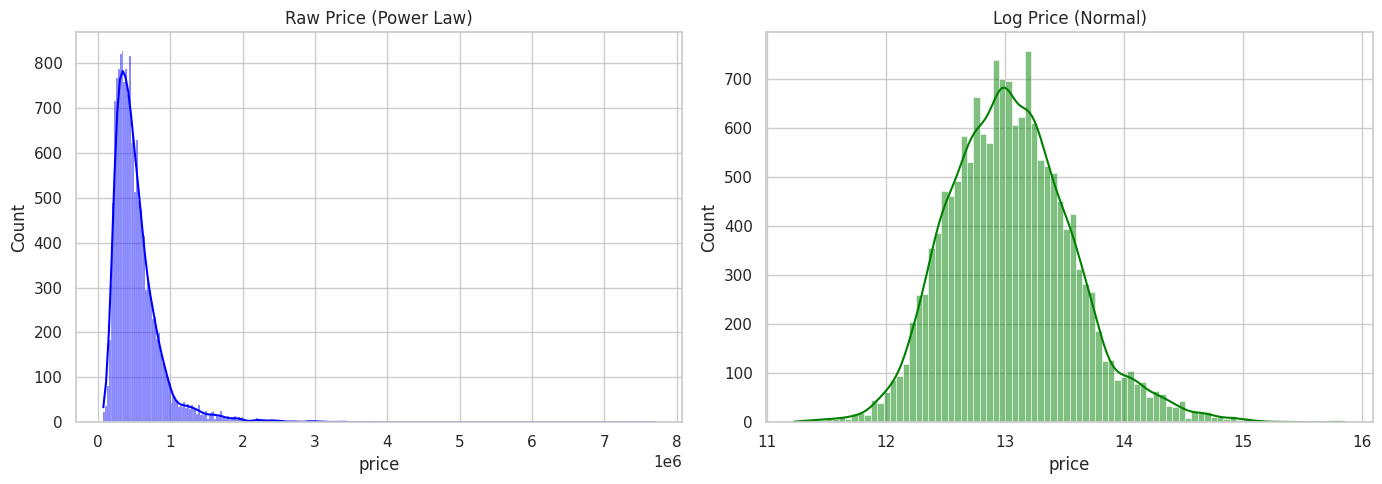

In [11]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(full_df['price'], kde=True, color='blue')
plt.title('Raw Price (Power Law)')
plt.subplot(1, 2, 2)
sns.histplot(np.log1p(full_df['price']), kde=True, color='green')
plt.title('Log Price (Normal)')
plt.tight_layout()
plt.show()

### 2.2 Bivariate: Features vs Price

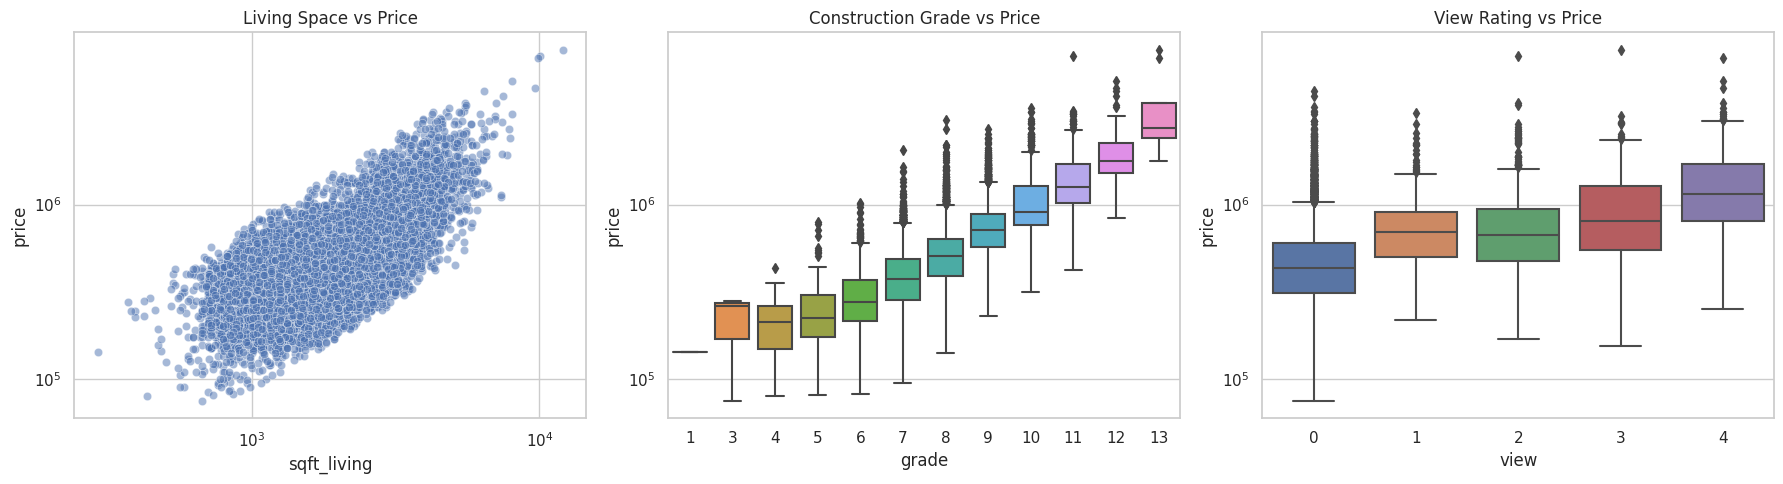

In [12]:
plt.figure(figsize=(18, 5))

# Sqft vs Price (Scatter)
plt.subplot(1, 3, 1)
sns.scatterplot(x='sqft_living', y='price', data=full_df, alpha=0.5)
plt.title('Living Space vs Price')
plt.yscale('log')
plt.xscale('log')

# Grade vs Price (Box)
plt.subplot(1, 3, 2)
sns.boxplot(x='grade', y='price', data=full_df)
plt.title('Construction Grade vs Price')
plt.yscale('log')

# View vs Price (Box)
plt.subplot(1, 3, 3)
sns.boxplot(x='view', y='price', data=full_df)
plt.title('View Rating vs Price')
plt.yscale('log')

plt.tight_layout()
plt.show()

### 2.3 Temporal: Year Built Analysis

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


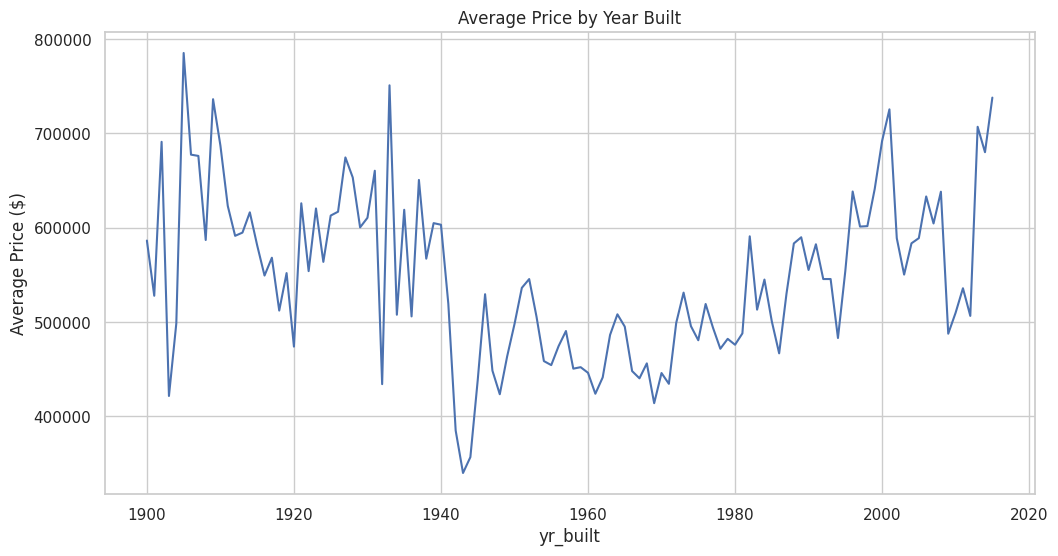

In [13]:
plt.figure(figsize=(12, 6))
avg_price_by_year = full_df.groupby('yr_built')['price'].mean()
sns.lineplot(data=avg_price_by_year)
plt.title('Average Price by Year Built')
plt.ylabel('Average Price ($)')
plt.show()

### 2.4 Correlation Heatmap

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


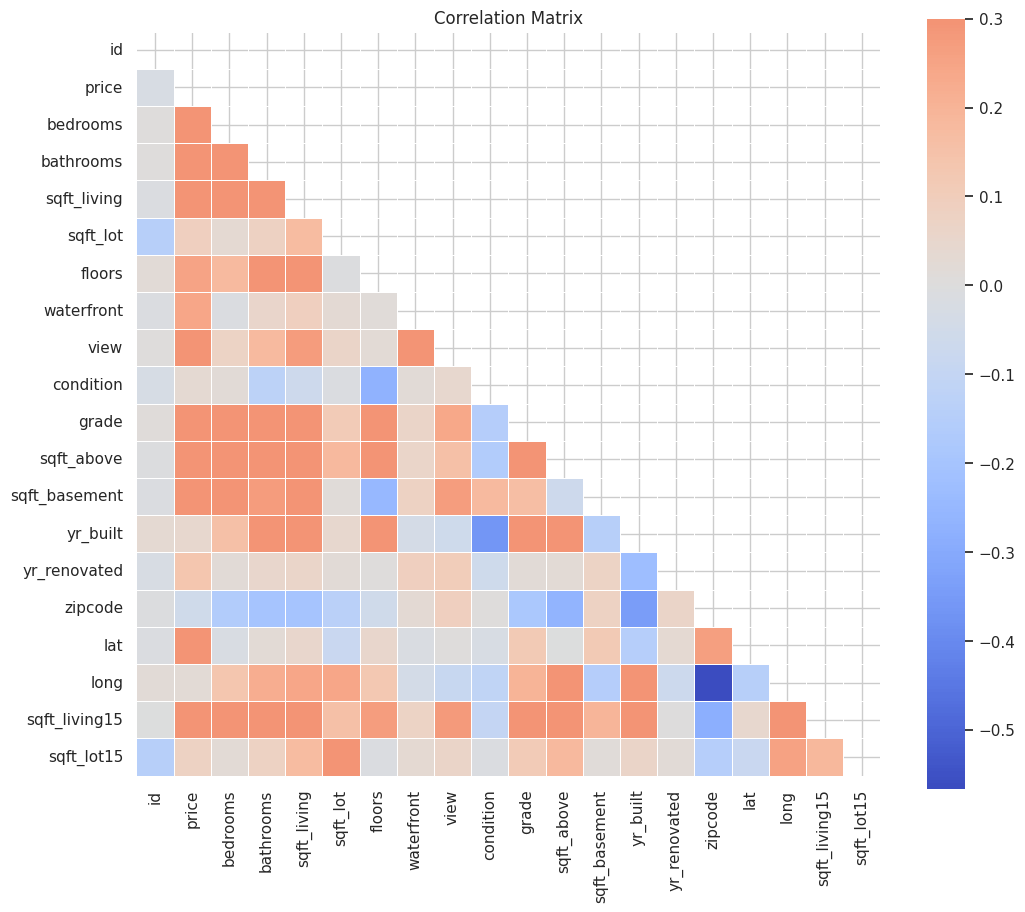

In [14]:
plt.figure(figsize=(12, 10))
numeric_df = full_df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=.3, center=0, square=True, linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

### 2.5 Tabular Insights (Zipcodes)

In [15]:
zip_stats = full_df.groupby('zipcode')['price'].agg(['count', 'mean', 'median'])
print("Top 10 Most Expensive Zipcodes:")
print(zip_stats.sort_values('mean', ascending=False).head(10))

Top 10 Most Expensive Zipcodes:
         count          mean     median
zipcode                                
98039       36  2.086929e+06  1912500.0
98004      233  1.327128e+06  1100000.0
98040      204  1.198328e+06   997000.0
98112      206  1.098771e+06   930000.0
98102       79  9.336901e+05   690000.0
98006      375  8.747259e+05   779000.0
98119      142  8.562714e+05   740000.0
98109       81  8.528373e+05   716000.0
98105      176  8.325499e+05   665000.0
98005      125  8.116100e+05   762450.0


### 2.6 Geospatial & Visual Analysis

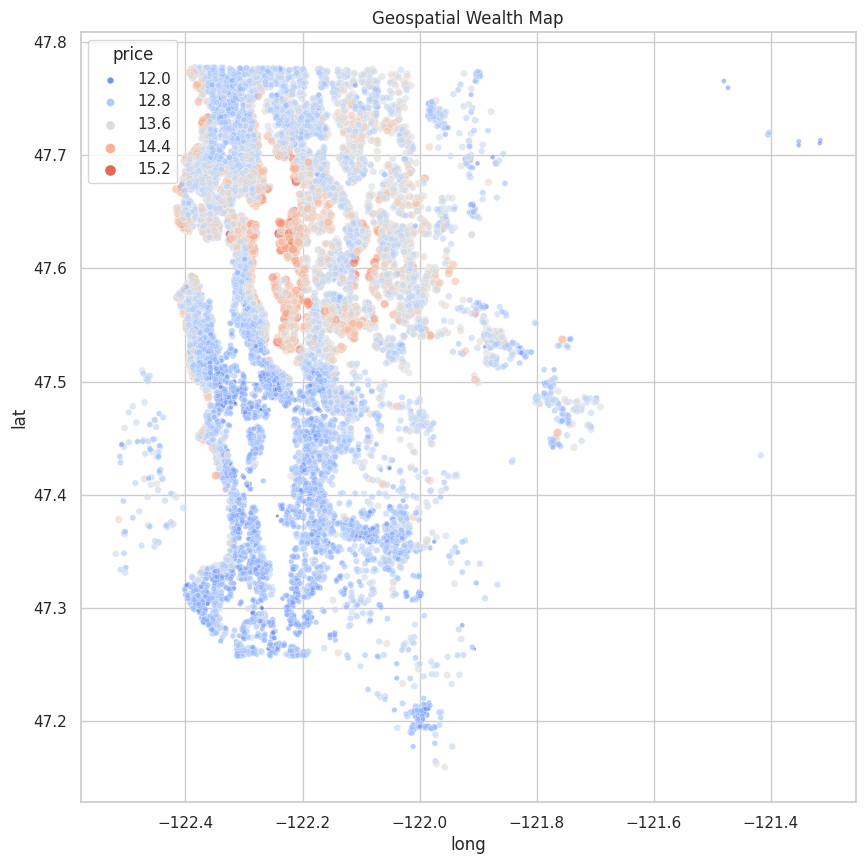

In [16]:
# Geospatial Map
plt.figure(figsize=(10, 10))
sns.scatterplot(
    x='long', y='lat', data=full_df, 
    hue=np.log1p(full_df['price']), palette='coolwarm', 
    alpha=0.6, size=np.log1p(full_df['price']), sizes=(5, 50)
)
plt.title('Geospatial Wealth Map')
plt.show()

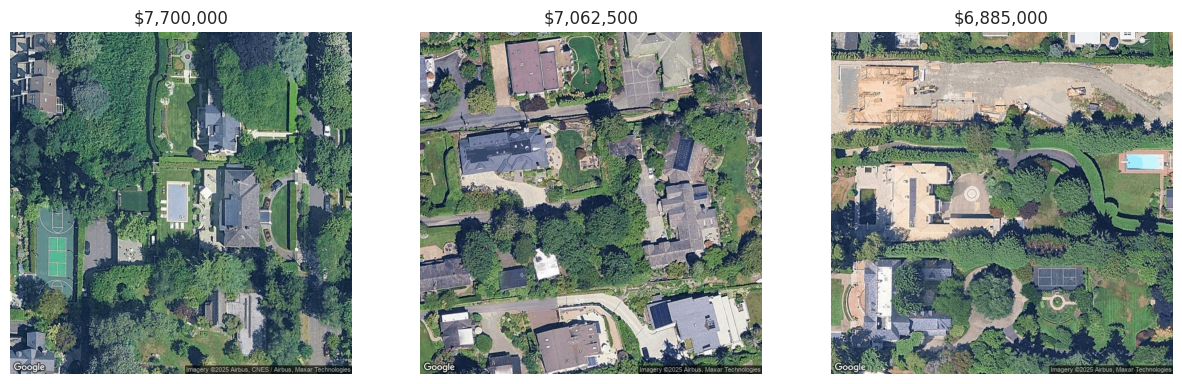

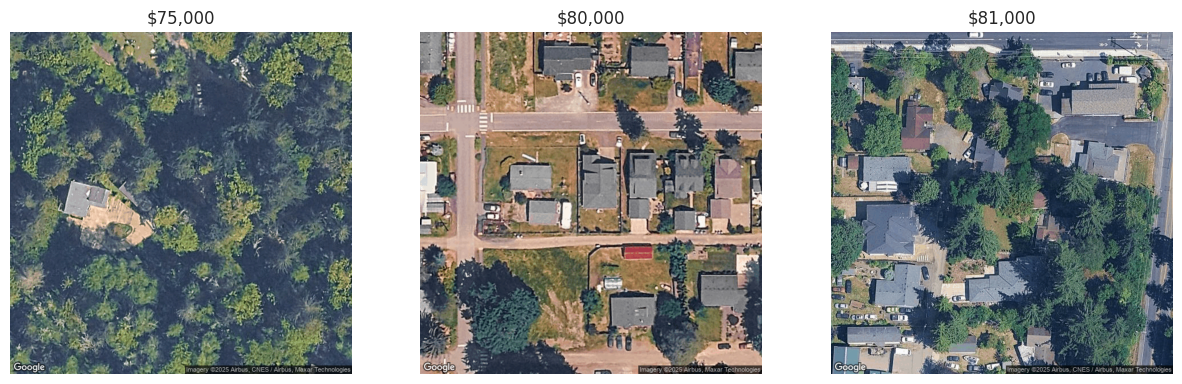

In [17]:
# Satellite Samples
def show_price_samples(df, img_dir, high_value=True, n=3):
    if not os.path.exists(img_dir): return
    sorted_df = df.sort_values('price', ascending=not high_value)
    samples = sorted_df.head(n)
    plt.figure(figsize=(15, 5))
    for i, (idx, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(img_dir, f"{int(row['id'])}.jpg")
        plt.subplot(1, n, i + 1)
        if os.path.exists(img_path):
            plt.imshow(Image.open(img_path))
            plt.title(f"${row['price']:,}")
        else:
            plt.text(0.5, 0.5, "Missing")
        plt.axis('off')
    plt.show()

show_price_samples(full_df, PATHS['images'], True, 3)
show_price_samples(full_df, PATHS['images'], False, 3)

## 3. Basic Feature Engineering

In [18]:
# Standard Features
full_df['sales_year'] = full_df['date'].dt.year
full_df['house_age'] = full_df['sales_year'] - full_df['yr_built']
full_df['is_renovated'] = full_df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
full_df['total_sqft'] = full_df['sqft_living'] + full_df['sqft_lot']

# Zipcode Encoding (Label)
lbl_enc = LabelEncoder()
full_df['zip_idx'] = lbl_enc.fit_transform(full_df['zipcode'])

# Split Train/Val
train_split, val_split = train_test_split(full_df, test_size=0.2, random_state=42)

print("Basic Feature Split Complete.")

Basic Feature Split Complete.


## 4. Advanced SOTA Feature Engineering (Spatial KNN)

In [19]:
def get_knn_features(fit_df, query_df, n_neighbors=10):
    X_fit = fit_df[['lat', 'long']].values
    X_query = query_df[['lat', 'long']].values
    is_self = (fit_df is query_df)
    k = n_neighbors + 1 if is_self else n_neighbors
    knn = NearestNeighbors(n_neighbors=k, n_jobs=-1)
    knn.fit(X_fit)
    _, indices = knn.kneighbors(X_query)
    new_feats_price, new_feats_sqft = [], []
    for i, neighbor_indices in enumerate(indices):
        real_neighbors = neighbor_indices[1:] if is_self else neighbor_indices
        nms = fit_df.iloc[real_neighbors]
        new_feats_price.append(np.mean(np.log1p(nms['price'])))
        new_feats_sqft.append(np.mean(nms['sqft_living']))
    return new_feats_price, new_feats_sqft

print("Generating KNN columns...")
train_split = train_split.copy()
val_split = val_split.copy()

t_p, t_s = get_knn_features(train_split, train_split)
train_split['knn_price'] = t_p
train_split['knn_sqft'] = t_s

v_p, v_s = get_knn_features(train_split, val_split)
val_split['knn_price'] = v_p
val_split['knn_sqft'] = v_s

print("KNN Features Added.")

Generating KNN columns...
KNN Features Added.


## 5. Dual Scalers & DataLoaders Setup

In [20]:
# Common Setup
drop_cols = ['id', 'date', 'price', 'zipcode', 'sales_year', 'zip_idx', 'knn_price', 'knn_sqft']
basic_feats = [c for c in train_split.columns if c not in drop_cols]
knn_feats = basic_feats + ['knn_price', 'knn_sqft']

# 1. BASIC SCALER
scaler_basic = StandardScaler()
X_train_basic = scaler_basic.fit_transform(train_split[basic_feats].fillna(0))
X_val_basic = scaler_basic.transform(val_split[basic_feats].fillna(0))

# 2. KNN SCALER
scaler_knn = StandardScaler()
X_train_knn = scaler_knn.fit_transform(train_split[knn_feats].fillna(0))
X_val_knn = scaler_knn.transform(val_split[knn_feats].fillna(0))

# Targets
y_train = np.log1p(train_split['price'].values)
y_val = np.log1p(val_split['price'].values)
z_train = train_split['zip_idx'].values
z_val = val_split['zip_idx'].values

class HouseDataset(Dataset):
    def __init__(self, df, features, zips, targets, img_dir, transform=None):
        self.ids = df['id'].values
        self.features = features
        self.zips = zips
        self.targets = targets
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        x_num = torch.tensor(self.features[idx], dtype=torch.float32)
        x_zip = torch.tensor(self.zips[idx], dtype=torch.long)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        img_id = str(int(self.ids[idx]))
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        image = Image.open(img_path).convert("RGB") if os.path.exists(img_path) else Image.new("RGB", (224, 224), (0, 0, 0))
        if self.transform:
            image = self.transform(image)
        return image, x_num, x_zip, y

tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("Pipelines Ready.")

Pipelines Ready.
